# Testing Source Extraction

Trying to take our single queried image and put it through SEP to get a segmentation map.

Primarily from the [SEP documentation](https://sep.readthedocs.io/en/stable/tutorial.html)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits as fits
from astropy.wcs import WCS
import sep

## Getting image

Loading up the image from decam. See query_images.ipynb for details.

In [13]:
import json
import requests
import pandas as pd

baseurl = "https://astroarchive.noirlab.edu/api"

url = f'{baseurl}/sia/vohdu?FORMAT=METADATA&format=json'

In [14]:
# simple image request of all the images within 1 degree of this ra and dec

# instrument: decam
instrument = 'decam'

# POS: position (ra,dec in degrees)
ra = 229.63841667
dec = 2.08102778   

# SIZE: angular size around position (degrees)
size = 1.0 

# limit: max number of records returned
limit = 10

# format: format of results (csv, xml, json)
format = 'json'

# image product type: we'll probably only be using 'image'
prod_type = 'image'
# image processing type: instacal / resampled / stacked / etc
image_type = 'resampled'

# this has a format of:
# vohdu?INPUT=value&INPUT=value
sia_request = f"{baseurl}/sia/vohdu?" + f"instrument={instrument}" +f"&POS={ra},{dec}" + f"&SIZE={size}" + \
    f"&prod_type={prod_type}" + f"&proc_type={image_type}" + f"&VERB=2" + f"&limit={limit}" + f"&format={format}"

# issue request and get data back in JSON format
sia_df = pd.DataFrame(requests.get(sia_request).json()[1:])

In [15]:
sia_df.columns

# index of a certain row from that (can be made from a condition) 
hdu_index = 2
# get the unique identifier for that row
file_id = sia_df['md5sum'][hdu_index]

single_image_url = f'{baseurl}/retrieve/{file_id}/?hdus={hdu_index}'
single_image_url = sia_df['url'][hdu_index]
print(single_image_url)

https://astroarchive.noirlab.edu/api/retrieve/01ba1fb0649b05b1195c84b63798b60f/?hdus=0,15


(1990, 3989)

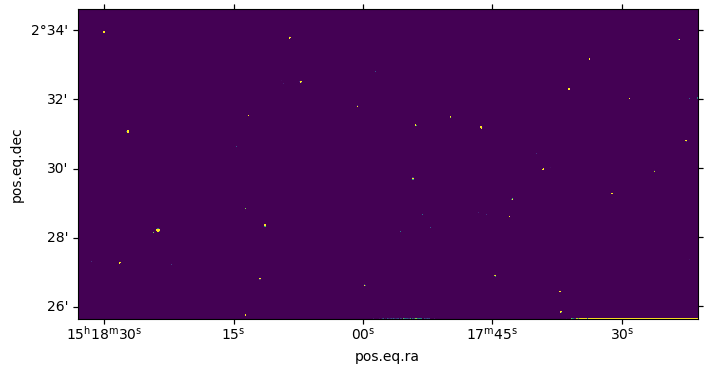

In [18]:
single_image = fits.open(single_image_url)

wcs = WCS(single_image[1].header)
zimage = single_image[1].data

fig = plt.figure(figsize=(8,16))
ax = plt.subplot(111, projection=wcs)
lon = ax.coords['ra']
lat = ax.coords['dec']
plt.imshow(zimage,vmin=90,vmax=200)
zimage.shape

In [48]:
objects = sep.extract(zimage, 50, segmentation_map=True)
len(objects)
objects

(array([(50.,   5,   5,  747,  751,    0,    0, 7.48365777e+02, 0.00000000e+00, 2.28285431e+00, 8.33333000e-02,  0.00000000e+00, 0., 0., 0.,  1.5109117 , 0.28867507,  0.00000000e+00, 4.38048095e-01,  12.00000477, -0.00000000e+00, 3.21530579e+02,  7.93691101e+02,    76.82363129,  2.54968109e+02,  747,    0,  747,    0, 11),
        (50.,   7,   7,  757,  763,    0,    0, 7.60621698e+02, 0.00000000e+00, 3.85289013e+00, 8.33333000e-02,  0.00000000e+00, 0., 0., 0.,  1.96287799, 0.28867507,  0.00000000e+00, 2.59545416e-01,  12.00000477, -0.00000000e+00, 4.54295898e+02,  1.10671826e+03,    86.65853882,  2.70308411e+02,  762,    0,  762,    0, 11),
        (50.,   8,   8,  780,  787,    0,    0, 7.83405551e+02, 0.00000000e+00, 4.81747090e+00, 8.33333000e-02,  0.00000000e+00, 0., 0., 0.,  2.19487381, 0.28867507,  0.00000000e+00, 2.07577795e-01,  12.00000477, -0.00000000e+00, 5.90792114e+02,  1.43815076e+03,    97.27016449,  2.71604828e+02,  782,    0,  785,    0, 10),
        (50.,  10,  10,  

TypeError: tuple indices must be integers or slices, not str

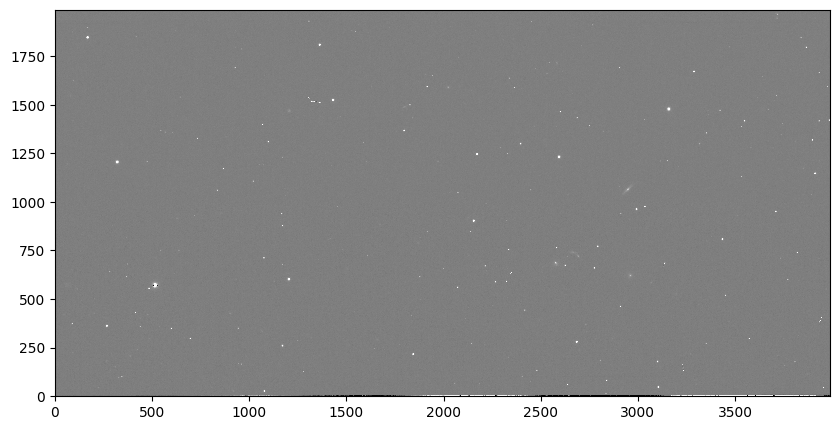

In [32]:

from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots(figsize=(10,10))
m, s = np.mean(zimage), np.std(zimage)
im = ax.imshow(zimage, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=100*objects['a'][i],
                height=100*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)